# Max Cut problem with VQE

### Problem description

A graph is an object that contains nodes and connections between those nodes. Connections are weighted with specific values. The problem consists in dividing the nodes in two families, such that the divisory lines crosses as much weight as possible. So for example, given the following graph, you can try and guess the best cut:
![](maxcut1.png)

The solution is given by the following cut:
![](maxcut2.png)

We can use some physics for describing this problem. We can define some sort of cost function representing a given cut in order to minimize. This cost function is given by $E = \frac{1}{2}(w_s-w_d)$, where $w_s$ are the weight between same color nodes, and $w_d$ between diferent color nodes. Given $N$ nodes, we can think that each noche might be red or blue, or alternativly 0 or 1. This new notation might wake our intuition up: qubits. The same should happen with our cost function being called $E$: energy. So we can think of this problem as finding the minimum state of N qubits given a hamiltonian. For example, given 3 nodes with certain weight, we could have the following hamiltonian:
![](maxcut3.png)

This is the Max cut problem, which is known to be NP-Complete. A diferent cost function can be given centered on the nodes instead of the connections: $C = \sum_{ij} w_{ij}x_i(1-x_j)$, where $x_k$ might be 0 or 1 depending on the group at which the node belongs. An extension can be given by considering individual weights: $C = \sum_{ij} w_{ij}x_i(1-x_j) + \sum_i w_i x_i$. This problem might be mapped directly into an Ising Hamiltonian by consiering the transformation $x_i\rightarrow (I-Z_i)/2$: 

$H = \sum_i x_i Z_i + \sum_{ij}w_{ij}Z_iZ_j$

Now we can perform VQE with this Hamiltonian. For this example, our ansatz will be given by $|\psi(\theta)\rangle = [U_{single}(\theta)U_{entangler}]^M|+\rangle$, with $U_{single}(\theta) = \prod_i^N Y(\theta_i)$ (N is the number of qubits and M the circuit's depth)

[Intuicion](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747)

[Bifes](https://quantum-computing.ibm.com/jupyter/tutorial/advanced/aqua/optimization/max_cut_and_tsp.ipynb)

In [3]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely


In [7]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to s

In [8]:
from qiskit import IBMQ
# provider = IBMQ.load_account()

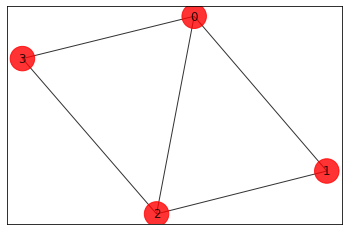

In [10]:
# Generating a graph of 4 nodes 

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [11]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


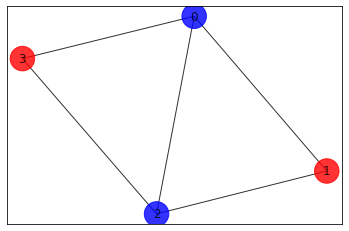

In [12]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))    

In [13]:
qubitOp, offset = max_cut.get_operator(w)

In [16]:
from docplex.mp.model import Model
from qiskit.optimization.applications.ising import docplex


# Create an instance of a model and variables.
mdl = Model(name='max_cut')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)}

# Object function
max_cut_func = mdl.sum(w[i,j]* x[i] * ( 1 - x[j] ) for i in range(n) for j in range(n))
mdl.maximize(max_cut_func)

# No constraints for Max-Cut problems.

In [17]:
qubitOp_docplex, offset_docplex = docplex.get_operator(mdl)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2020-07-17 20:51:15,289:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-1.5+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-1.5]),
    'energy': -1.5,
    'wavefunction': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}
2020-07-17 20:51:15,295:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)],

energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


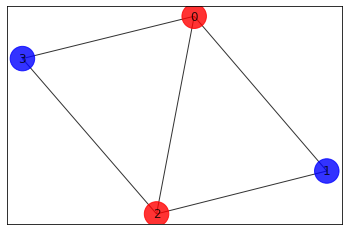

In [18]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  after removing the cwd from sys.path.
2020-07-17 20:51:27,552:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f06fd9a3da0>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:28,594:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.03721405] - 49.51239 (ms), eval count: 5
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:28,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.04567929] - 74.60332 (ms), eval count: 6
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-p

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:29,224:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.24948706] - 26.33309 (ms), eval count: 22
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:29,253:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.27877384] - 25.94829 (ms), eval count: 23
/home/marco/miniconda3/envs/tequila/lib/python3.7/site

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:29,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.06926005] - 25.63930 (ms), eval count: 40
2020-07-17 20:51:29,741:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 20 of 25
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:29,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:30,218:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.11844885] - 27.31776 (ms), eval count: 56
2020-07-17 20:51:30,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: -0.1575107
2020-07-17 20:51:30,222:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: -0.1184488
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:30,944:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.22902148] - 32.43279 (ms), eval count: 70
2020-07-17 20:51:30,946:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 9: -0.2029686
2020-07-17 20:51:30,947:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 9: -0.2290215
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:31,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.43409477] - 29.83451 (ms), eval count: 84
2020-07-17 20:51:31,413:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 16: -0.4104472
2020-07-17 20:51:31,415:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 16: -0.4340948
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scal

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:31,846:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.81666148] - 24.95599 (ms), eval count: 98
2020-07-17 20:51:31,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: -0.8840273
2020-07-17 20:51:31,850:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: -0.8166615
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scal

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:32,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.93628112] - 33.11944 (ms), eval count: 112
2020-07-17 20:51:32,301:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 30: -0.9146140
2020-07-17 20:51:32,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 30: -0.9362811
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:32,754:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.94885403] - 23.64779 (ms), eval count: 126
2020-07-17 20:51:32,756:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 37: -1.0006610
2020-07-17 20:51:32,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 37: -0.9488540
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:33,256:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.11623649] - 24.44577 (ms), eval count: 140
2020-07-17 20:51:33,258:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: -1.0718161
2020-07-17 20:51:33,260:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: -1.1162365
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:33,682:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.20714216] - 25.85053 (ms), eval count: 154
2020-07-17 20:51:33,684:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 51: -1.1018102
2020-07-17 20:51:33,685:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 51: -1.2071422
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:34,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.14891081] - 48.54488 (ms), eval count: 168
2020-07-17 20:51:34,219:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: -1.2430338
2020-07-17 20:51:34,220:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: -1.1489108
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:34,602:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.26220741] - 24.84679 (ms), eval count: 182
2020-07-17 20:51:34,603:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: -1.2951052
2020-07-17 20:51:34,605:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: -1.2622074
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:35,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.33730272] - 19.71698 (ms), eval count: 196
2020-07-17 20:51:35,054:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 72: -1.2253082
2020-07-17 20:51:35,055:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 72: -1.3373027
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:35,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.36850408] - 23.25177 (ms), eval count: 210
2020-07-17 20:51:35,503:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: -1.3708334
2020-07-17 20:51:35,505:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 79: -1.3685041
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:35,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.31910799] - 28.89895 (ms), eval count: 224
2020-07-17 20:51:35,972:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 86: -1.3913161
2020-07-17 20:51:35,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 86: -1.3191080
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:36,446:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.39702883] - 30.29370 (ms), eval count: 238
2020-07-17 20:51:36,448:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: -1.3640806
2020-07-17 20:51:36,452:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: -1.3970288
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sca

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:36,882:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.43668475] - 24.57738 (ms), eval count: 252
2020-07-17 20:51:36,883:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: -1.4001421
2020-07-17 20:51:36,884:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 100: -1.4366847
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:37,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.38226861] - 25.18153 (ms), eval count: 266
2020-07-17 20:51:37,358:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 107: -1.4510342
2020-07-17 20:51:37,360:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 107: -1.3822686
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:37,817:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45746182] - 27.60434 (ms), eval count: 280
2020-07-17 20:51:37,818:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: -1.4354921
2020-07-17 20:51:37,820:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: -1.4574618
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:38,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.42117865] - 30.40624 (ms), eval count: 294
2020-07-17 20:51:38,372:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 121: -1.4503444
2020-07-17 20:51:38,374:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 121: -1.4211786
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:38,931:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45882403] - 29.61373 (ms), eval count: 308
2020-07-17 20:51:38,933:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: -1.4442580
2020-07-17 20:51:38,935:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: -1.4588240
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:39,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.40136599] - 28.67675 (ms), eval count: 322
2020-07-17 20:51:39,409:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 135: -1.4508926
2020-07-17 20:51:39,411:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 135: -1.4013660
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:39,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47114224] - 24.51324 (ms), eval count: 336
2020-07-17 20:51:39,858:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: -1.4499192
2020-07-17 20:51:39,859:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 142: -1.4711422
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:40,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.44148631] - 23.51022 (ms), eval count: 350
2020-07-17 20:51:40,295:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: -1.4691402
2020-07-17 20:51:40,296:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: -1.4414863
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:40,736:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47285986] - 28.28002 (ms), eval count: 364
2020-07-17 20:51:40,738:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 156: -1.4484729
2020-07-17 20:51:40,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 156: -1.4728599
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:41,201:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48236167] - 38.57327 (ms), eval count: 378
2020-07-17 20:51:41,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: -1.4727392
2020-07-17 20:51:41,204:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: -1.4823617
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:41,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46383103] - 33.64277 (ms), eval count: 392
2020-07-17 20:51:41,731:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 170: -1.4629904
2020-07-17 20:51:41,733:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 170: -1.4638310
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:42,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45696813] - 30.39765 (ms), eval count: 406
2020-07-17 20:51:42,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: -1.4811067
2020-07-17 20:51:42,232:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: -1.4569681
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:42,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46737536] - 30.11632 (ms), eval count: 420
2020-07-17 20:51:42,747:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: -1.4613419
2020-07-17 20:51:42,748:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: -1.4673754
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:43,249:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46410134] - 36.63540 (ms), eval count: 434
2020-07-17 20:51:43,251:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 191: -1.4718177
2020-07-17 20:51:43,252:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 191: -1.4641013
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:43,722:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46483457] - 35.50315 (ms), eval count: 448
2020-07-17 20:51:43,725:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: -1.4515414
2020-07-17 20:51:43,726:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: -1.4648346
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

2020-07-17 20:51:44,186:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47361501] - 32.14359 (ms), eval count: 461
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:44,217:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47844065] - 29.10304 (ms), eval count: 462
2020-07-17 20:51:44,221:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 205: -1.4736150
2020-07-17 20:51:44,222:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 205: -1.4784407
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: 

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:44,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45995323] - 21.15250 (ms), eval count: 476
2020-07-17 20:51:44,685:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 212: -1.4603204
2020-07-17 20:51:44,687:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 212: -1.4599532
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:45,166:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46867789] - 22.81404 (ms), eval count: 490
2020-07-17 20:51:45,168:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 219: -1.4802928
2020-07-17 20:51:45,169:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 219: -1.4686779
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:45,643:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.44369819] - 28.57757 (ms), eval count: 504
2020-07-17 20:51:45,644:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 226: -1.4519799
2020-07-17 20:51:45,646:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 226: -1.4436982
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:46,233:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47232166] - 37.16707 (ms), eval count: 518
2020-07-17 20:51:46,235:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 233: -1.4666563
2020-07-17 20:51:46,236:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 233: -1.4723217
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:46,626:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4414724] - 27.24862 (ms), eval count: 532
2020-07-17 20:51:46,628:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: -1.4457177
2020-07-17 20:51:46,630:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: -1.4414724
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `sc

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:47,225:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47525089] - 26.42226 (ms), eval count: 546
2020-07-17 20:51:47,227:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 247: -1.4632947
2020-07-17 20:51:47,229:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 247: -1.4752509
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:47,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46934888] - 49.94607 (ms), eval count: 560
2020-07-17 20:51:47,857:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 254: -1.4828901
2020-07-17 20:51:47,859:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 254: -1.4693489
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:48,480:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47932022] - 28.23973 (ms), eval count: 574
2020-07-17 20:51:48,482:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 261: -1.4686002
2020-07-17 20:51:48,483:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 261: -1.4793202
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:48,914:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46880698] - 26.97420 (ms), eval count: 588
2020-07-17 20:51:48,916:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 268: -1.4607682
2020-07-17 20:51:48,917:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 268: -1.4688070
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

2020-07-17 20:51:49,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47177195] - 29.69241 (ms), eval count: 601
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:49,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47492949] - 40.11941 (ms), eval count: 602
2020-07-17 20:51:49,401:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 275: -1.4717719
2020-07-17 20:51:49,403:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 275: -1.4749295
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: 

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:49,877:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47139362] - 30.67160 (ms), eval count: 616
2020-07-17 20:51:49,879:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 282: -1.4702799
2020-07-17 20:51:49,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 282: -1.4713936
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:50,383:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.45994139] - 30.91955 (ms), eval count: 630
2020-07-17 20:51:50,384:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 289: -1.4569150
2020-07-17 20:51:50,386:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 289: -1.4599414
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:51:50,846:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48560602] - 27.80747 (ms), eval count: 644
2020-07-17 20:51:50,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 296: -1.4919914
2020-07-17 20:51:50,849:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 296: -1.4856060
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `s

energy: -1.49499441010023
time: 23.441097736358643
max-cut objective: -3.99499441010023
solution: [0. 1. 0. 1.]
solution objective: 4.0


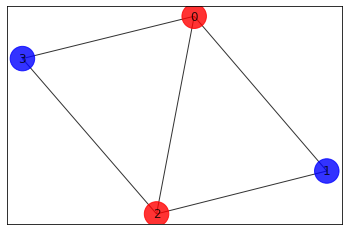

In [19]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  """
2020-07-17 20:52:01,785:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f06fd90c588>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f06fd90cc50>>
-- initial_point: Ra

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:03,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.22460938] - 75.67716 (ms), eval count: 26
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wil

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:03,806:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:05,037:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.06445312] - 65.59992 (ms), eval count: 51
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will

2020-07-17 20:52:05,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 2: -0.3544922
2020-07-17 20:52:05,384:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 2: -0.3046875
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py

2020-07-17 20:52:05,690:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.49707031] - 50.80485 (ms), eval count: 61
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wil

2020-07-17 20:52:06,123:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 7: -0.3281250
2020-07-17 20:52:06,124:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 7: -0.3984375
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:06,466:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.30566406] - 60.00662 (ms), eval count: 71
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wil

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:07,072:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 14: -0.5361328
2020-07-17 20:52:07,074:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 14: -0.5917969
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:07,761:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.58789062] - 53.05600 (ms), eval count: 90
2020-07-17 20:52:07,763:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: -0.8574219
2020-07-17 20:52:07,764:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 19: -0.5878906
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.r

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:08,688:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 26: -0.9443359
2020-07-17 20:52:08,690:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 26: -1.0283203
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:09,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.26367188] - 76.13254 (ms), eval count: 114
2020-07-17 20:52:09,309:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 31: -1.0244141
2020-07-17 20:52:09,311:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 31: -1.2636719
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:10,191:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 38: -1.3056641
2020-07-17 20:52:10,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 38: -1.2763672
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:10,800:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: -1.3476562
2020-07-17 20:52:10,801:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: -1.3427734
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:11,505:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: -1.3554688
2020-07-17 20:52:11,506:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: -1.3408203
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:12,098:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: -1.3867188
2020-07-17 20:52:12,099:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: -1.2880859
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:12,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.36328125] - 57.11985 (ms), eval count: 168
2020-07-17 20:52:12,714:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: -1.4082031
2020-07-17 20:52:12,715:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: -1.3632812
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:13,575:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 65: -1.4443359
2020-07-17 20:52:13,577:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 65: -1.3730469
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:14,173:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: -1.4365234
2020-07-17 20:52:14,175:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: -1.4335938
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:14,730:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 75: -1.4677734
2020-07-17 20:52:14,732:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 75: -1.4736328
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:15,299:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: -1.4453125
2020-07-17 20:52:15,300:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: -1.4140625
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:15,876:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 85: -1.4707031
2020-07-17 20:52:15,878:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 85: -1.4755859
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:16,431:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 90: -1.4599609
2020-07-17 20:52:16,433:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 90: -1.4609375
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:17,002:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: -1.4843750
2020-07-17 20:52:17,004:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: -1.4765625
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:17,553:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47851562] - 50.61984 (ms), eval count: 252
2020-07-17 20:52:17,555:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 100: -1.4843750
2020-07-17 20:52:17,556:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-17 20:52:17,772:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 102: -1.4482422
2020-07-17 20:52:17,775:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 102: -1.4482422
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:18,314:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.4921875] - 44.29817 (ms), eval count: 266
2020-07-17 20:52:18,316:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 107: -1.4853516
2020-07-17 20:52:18,317:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective fu

2020-07-17 20:52:18,534:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 109: -1.4765625
2020-07-17 20:52:18,536:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 109: -1.4843750
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:19,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.46289062] - 43.84661 (ms), eval count: 280
2020-07-17 20:52:19,070:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: -1.4570312
2020-07-17 20:52:19,071:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-17 20:52:19,257:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: -1.4765625
2020-07-17 20:52:19,258:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: -1.4599609
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:19,788:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47167969] - 37.84132 (ms), eval count: 294
2020-07-17 20:52:19,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 121: -1.4648438
2020-07-17 20:52:19,793:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 121: -1.4716797
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scala

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:20,594:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: -1.4628906
2020-07-17 20:52:20,596:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: -1.4648438
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:21,188:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 133: -1.4677734
2020-07-17 20:52:21,191:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 133: -1.4716797
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:21,738:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 138: -1.4687500
2020-07-17 20:52:21,740:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 138: -1.4687500
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:22,333:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 143: -1.4785156
2020-07-17 20:52:22,335:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 143: -1.4824219
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:22,609:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.47851562] - 45.52269 (ms), eval count: 343
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and wi

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:23,226:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: -1.4550781
2020-07-17 20:52:23,227:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: -1.4658203
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:23,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.484375] - 55.24492 (ms), eval count: 362
2020-07-17 20:52:23,759:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 155: -1.4882812
2020-07-17 20:52:23,760:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 155: -1.4843750
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:24,546:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 162: -1.4804688
2020-07-17 20:52:24,548:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 162: -1.4951172
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:25,104:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 167: -1.4707031
2020-07-17 20:52:25,105:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 167: -1.4648438
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:25,668:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 172: -1.4892578
2020-07-17 20:52:25,670:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 172: -1.4873047
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:26,219:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 177: -1.4990234
2020-07-17 20:52:26,219:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 177: -1.4941406
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:26,525:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:27,017:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: -1.4677734
2020-07-17 20:52:27,019:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: -1.4697266
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:27,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.49023438] - 45.52293 (ms), eval count: 430
2020-07-17 20:52:27,550:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 189: -1.4892578
2020-07-17 20:52:27,552:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-17 20:52:27,765:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 191: -1.4716797
2020-07-17 20:52:27,766:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 191: -1.4736328
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:28,291:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 196: -1.4804688
2020-07-17 20:52:28,293:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 196: -1.4824219
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:28,865:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 201: -1.4580078
2020-07-17 20:52:28,867:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 201: -1.4453125
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:29,402:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 206: -1.4716797
2020-07-17 20:52:29,403:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 206: -1.4843750
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:29,815:qiskit.aqua.algo

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:30,440:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 213: -1.4765625
2020-07-17 20:52:30,442:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 213: -1.4824219
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
2020-07-17 20:52:30,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.48632812] - 46.49472 (ms), eval count: 488
2020-07-17 20:52:30,991:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 218: -1.4804688
2020-07-17 20:52:30,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective f

2020-07-17 20:52:31,216:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 220: -1.4892578
2020-07-17 20:52:31,217:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 220: -1.4951172
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:31,769:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 225: -1.4892578
2020-07-17 20:52:31,771:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 225: -1.4902344
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:32,263:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 230: -1.4794922
2020-07-17 20:52:32,267:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 230: -1.4726562
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:32,776:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 235: -1.4736328
2020-07-17 20:52:32,778:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 235: -1.4785156
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:33,329:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: -1.4794922
2020-07-17 20:52:33,330:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: -1.4785156
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:33,892:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 245: -1.4726562
2020-07-17 20:52:33,893:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 245: -1.4785156
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:34,458:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 250: -1.4921875
2020-07-17 20:52:34,460:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 250: -1.4882812
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:35,058:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 255: -1.4707031
2020-07-17 20:52:35,059:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 255: -1.4873047
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:35,639:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 260: -1.4804688
2020-07-17 20:52:35,641:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 260: -1.4736328
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:36,206:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 265: -1.4570312
2020-07-17 20:52:36,207:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 265: -1.4667969
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:36,764:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 270: -1.4707031
2020-07-17 20:52:36,764:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 270: -1.4707031
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:37,325:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 275: -1.4814453
2020-07-17 20:52:37,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 275: -1.4902344
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:37,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 280: -1.4824219
2020-07-17 20:52:37,875:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 280: -1.4785156
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:38,403:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 285: -1.4960938
2020-07-17 20:52:38,404:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 285: -1.4960938
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:38,973:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 290: -1.4873047
2020-07-17 20:52:38,975:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 290: -1.4912109
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

2020-07-17 20:52:39,548:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 295: -1.4707031
2020-07-17 20:52:39,549:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 295: -1.4667969
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_f

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/dict_state_fn.py:209: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/home/marco/miniconda3/envs/tequila/lib/

energy: -1.5
time: 38.22538185119629
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


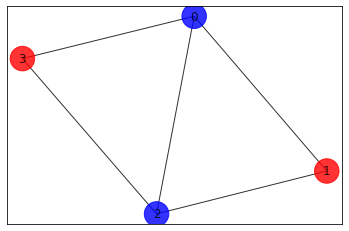

In [20]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/numpy_eigen_solver.py:242: DeprecationWarning: Deprecated class ExactEigensolver, use NumPyEigensolver.
  DeprecationWarning)
2020-07-17 20:52:40,694:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-1.5+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-1.5]),
    'energy': -1.5,
    'wavefunction': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}
2020-07-17 20:52:40,698:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)],

energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


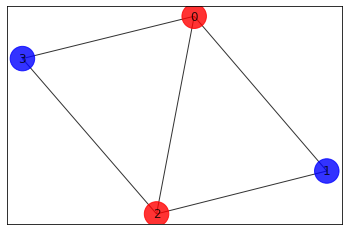

In [21]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp_docplex, k=1)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset_docplex)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)